# Introduction

This exercise will introduce how to assign time series to stress pacakges. 

**From the MODFLOW 6 Manual:**

Any package that reads data as a list of cells and associated time-dependent input values can obtain
those values from time series. For example, flow rates for a well or stage for a river boundary can
be extracted from time series. During a simulation, values used for time-varying stresses (or auxiliary
values) are based on the values provided in the time series and are updated each time step (or each
subtime step, as appropriate).

In [1]:
# Import necessary libraries
# for the purposes of this course we are using frozen versions of flopy to avoid depenecy failures.  
import os 
import sys
sys.path.append('../dependencies/')
import flopy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load a Model

In this exercise we will modify the model constructed in exercise 06. This will give us some practice in loading and modifying existing models. 

In this case, we will load the existing model, remove the existing WEL package and then construct a new WEL package using time-series to specify pumping rates during the second (transient) stress period.

In [2]:
# As in the previous exercise, if you do not have MODFLOW 6 in yout system path, you must provide the location of the executable file
# The MODFLOW 6 executable is named "mf6.exe":
exe_name = os.path.join('..','bin', 'mf6.exe')

# define the location of the model working directory;  this is where the existing model is currently stored. We are going to load the model constructed during exercise 01.
org_workspace = os.path.join('..','models','symple_ex06')

# define a new model working directory
workspace = os.path.join('..','models','symple_ex07')

# load the Simulation
sim = flopy.mf6.MFSimulation.load(sim_name='symple_ex07', 
                                    exe_name=exe_name, 
                                    sim_ws=org_workspace)
# change the model workspace to a new folder
sim.set_sim_path(workspace)

# access the Model Object using the model name
gwf = sim.get_model(list(sim.model_names)[0])

# check the package names
print(gwf.get_package_list())

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package npf...
    loading package rch...
    loading package wel...
    loading package oc...
    loading package sto...
    loading package riv...
    loading package obs...
  loading ims package symp06...
['DIS', 'IC', 'NPF', 'RCH', 'WEL_0', 'OC', 'STO', 'RIV_OBS', 'RIV_0', 'OBS_1']


In [3]:
# remove the existing WEL package
gwf.remove_package("WEL_0")

print(gwf.get_package_list())

['DIS', 'IC', 'NPF', 'RCH', 'OC', 'STO', 'RIV_OBS', 'RIV_0', 'OBS_1']


## **Construct a New WEL Package**

Now we will reconstrcut the WEL pacakge using time series data. First we need to have some time series data.

Time series data are constructed as a list of tuples. Each tuple contains the time and one or more values specified at that time. For example: (time, val1, val2)

Additionaly, a "time series namerecord" (i.e. the time series name) and a "interpolation_methodrecord" are required for each value in the ts data tuple. The namerecord is used to assign the time series to cells when p=constructing the stress package. The interpolation_methodrecord specifies how the time series values are interpolated between listed times.

For this exercise we will assign two diferent time series to two wells. Each well (i.e. each time series) will pump at a diferent rate. Both wells will pump for 182.5 days at full capacity, then recude to 50% for the remainder of the stress period. We will name these tie series "well1" and "well2" and use STEPWISE interpolation (see the MF6 manual for more info on available interpolation methods).

In [4]:
# ts data
val1 = -100
val2 = -5

ts_data = [
            (1, val1, val2), #the transeint stress period starts on day 1. The time series could begin at day 0, it wouldnt matter as it is not assigned during the first sress period
            (182.5, val1*0.5, val2*0.5),
            (366, val1*0.5, val2*0.5) # we must asign a value at the end of the model run. 
            ]

#ts names
ts_names = ['well1', 'well2']

# interpolation methods
ts_methods = ['stepwise', 'stepwise']

In [5]:
# Now when we construct the WEL pakcage list data, instead of a pumping rate, we assign a time series namerecord 
wel_spd={}
# set no pumping in the first stress period
wel_spd[0] = []
# set pumping in the second (transient) stress period. Let's also add some observations so that we can record the pumping rate.
wel_spd[1] = [ ((2, 5, 3), 'well1', 'w1'), 
                ((2, 10, 6), 'well2', 'w2')]

# construct the WEL pacakge
wel = flopy.mf6.ModflowGwfwel(gwf, stress_period_data=wel_spd,
                                    print_input=True, 
                                    print_flows=True,
                                    save_flows=True,
                                    boundnames=True)

# Now initialize the pacakge's time series 
wel.ts.initialize(filename='wel.ts', # the filename which MODFLOW will use to read the time series
                    timeseries=ts_data,
                    time_series_namerecord=ts_names,
                    interpolation_methodrecord=ts_methods
                    )

# Add the observations
wel_obs = {'wel_obs.csv': [('wel1', 'WEL', 'w1') , ('wel2', 'WEL', 'w2') ]}
wel.obs.initialize(digits=10, 
                    print_input=False,
                    continuous=wel_obs)

In [6]:
sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package symp06...
  writing model symp06...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package rch...
    writing package oc...
    writing package sto...
    writing package riv_obs...
    writing package riv_0...
    writing package obs_1...
    writing package wel_0...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 2 based on size of stress_period_data
    writing package ts_0...
    writing package obs_0...
FloPy is using the following  executable to run the model: ..\bin\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.2.1 02/18/2021

   MODFLOW 6 compiled Feb 18 2021 08:24:05 with IFORT compiler (ver. 19.10.2)

This software has been approved for release by the U.S. Geologi

(True, [])

In [7]:
# access a list of observation ouput file names of the firs OBS package
gwf.obs[2].output.obs_names

['wel_obs.csv']

<AxesSubplot:xlabel='totim'>

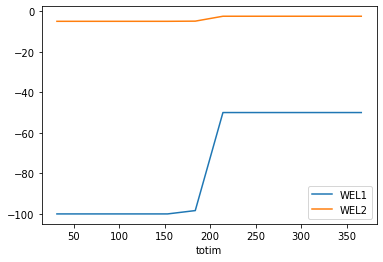

In [8]:
# plot the tie series of pumping rate
welobs_data = gwf.obs[2].output.obs(f='wel_obs.csv').data

welobs_df = pd.DataFrame(welobs_data).replace(3e30, np.nan)

welobs_df.plot(x='totim')